### PROJECT-IV BEE CLASSIFICATION

Submitted By: Anish Bhusal (bhusal.anish12@gmail.com)

**Import necessary libraries**

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,f1_score
from sklearn import metrics
from skimage import feature, io
from skimage import io

**1. Load Dataset**

In [2]:
labels_df=pd.read_csv("../data/Project-IV/labels.csv",index_col=0)

In [3]:
labels_df.head()

,genus
id,
520,1.0
3800,1.0
3289,1.0
2695,1.0
4922,1.0


**2. Data Analysis and Visualization**

In [4]:
labels_df["genus"].unique()

array([1., 0.])

There are two kinds of labels. "1" is for Bumblee Bee and another is for Honey Bee

In [5]:
print("shape of labels file {}".format(labels_df.shape))

shape of labels file (3969, 1)


In [6]:
labels_df.isna().sum() #check for nans

genus    0
dtype: int64

In [7]:
def get_image(row_id, root='../data/Project-IV/images/'):
    
    filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = io.imread(file_path)
    
    return img

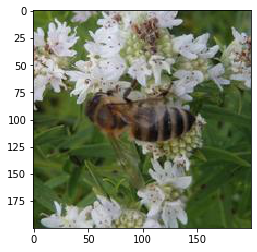

In [8]:
# Visualize Honey Bee
honey_bee_row = labels_df[labels_df.genus==0.0].index[5]
honey_bee = get_image(honey_bee_row)
plt.imshow(honey_bee)

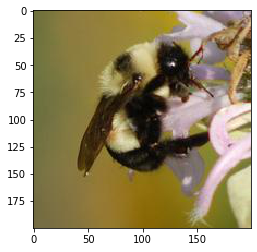

In [9]:
# Visualize Bumblee Bee
bumblee_bee_row = labels_df[labels_df.genus==1.0].index[5]
bumblee_bee = get_image(bumblee_bee_row)
plt.imshow(bumblee_bee)

Honey Bee Count: 827 Bumblee Bee Count: 3142


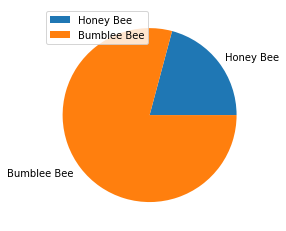

In [10]:
honey_bee_count=len(labels_df[labels_df.genus==0.])
bumblee_bee_count=len(labels_df[labels_df.genus==1.])
print("Honey Bee Count: {} Bumblee Bee Count: {}".format(honey_bee_count,bumblee_bee_count))
total_c=labels_df.shape[0]
plt.pie(x=[honey_bee_count,bumblee_bee_count],labels=["Honey Bee","Bumblee Bee"])
plt.legend()
plt.show()

**3. Feature Extraction and Pre-processing**


Extract HOG feature and create a dataset X,y with features,labels

In [11]:
X=[]
y=[]

#extract hog features
for img_id in labels_df.index:
    img=get_image(img_id)
    X.append(feature.hog(img,pixels_per_cell=(48,48)))
    y.append(labels_df.loc[img_id]["genus"])

Split the dataset into train and test data with 75%-25% split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.25, random_state=27)

**4. Grid Search**

In [13]:
classifiers={
    "svm":SVC(),
    "decision_tree":DecisionTreeClassifier(),
    "random_forest":RandomForestClassifier(),
    
}

In [14]:
grid_params={
    "svm":{
        'kernel':('linear','rbf'),
        'C':(2,20)
    },
    "decision_tree":{
        'max_depth':(9,11,13),
        'min_samples_split':(4,6,8,10),
        
    },
    "random_forest":{
         'n_estimators':(5,8,11,13),
         'max_depth':(9, 11, 13),
         'min_samples_split': (4, 6, 8, 10),
    }
}

In [15]:
final_clf=[]
for clf_label,model in classifiers.items():
    scorer=make_scorer(f1_score,average='micro')
    clf=GridSearchCV(model,grid_params[clf_label],scoring=scorer)
    clf.fit(X_train,y_train)
    final_clf.append(clf)
    print("Model:{} The best score is: {} with params {}".format(clf_label,clf.best_score_,clf.best_params_))

Model:svm The best score is: 0.7923382775929163 with params {'C': 2, 'kernel': 'rbf'}
Model:decision_tree The best score is: 0.7258067790874739 with params {'max_depth': 9, 'min_samples_split': 6}
Model:random_forest The best score is: 0.791666572669336 with params {'max_depth': 11, 'min_samples_split': 4, 'n_estimators': 13}


Save models 

In [16]:
import pickle
pickle.dump(final_clf[0],open("svm_model","wb"))
pickle.dump(final_clf[1],open("decision_tree_model","wb"))
pickle.dump(final_clf[2],open("random_forest_model","wb"))

**5. Model Evaluation**

In [17]:
final_models={
    "svm":final_clf[0],
    "decison_tree":final_clf[1],
    "random_forest":final_clf[2]
}

In [18]:
for model_name,classifier in final_models.items():
    print("Evaluating model: {} for test set".format(model_name))
    print("--------------------------------------------")
    y_pred=classifier.predict(X_test)
    print(metrics.classification_report(y_test,y_pred))
    print("--------------------------------------------")

Evaluating model: svm for test set
--------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.02      0.05       207
         1.0       0.80      1.00      0.89       786

    accuracy                           0.80       993
   macro avg       0.90      0.51      0.47       993
weighted avg       0.84      0.80      0.71       993

--------------------------------------------
Evaluating model: decison_tree for test set
--------------------------------------------
              precision    recall  f1-score   support

         0.0       0.28      0.20      0.23       207
         1.0       0.80      0.86      0.83       786

    accuracy                           0.72       993
   macro avg       0.54      0.53      0.53       993
weighted avg       0.69      0.72      0.71       993

--------------------------------------------
Evaluating model: random_forest for test set
------------------------------------------

This is an imbalanced dataset, so we need to use Recall metric for evaluating the performance. From above report, Random tree is showing better performance with 0.51 recall and 79% accuracy.

**Visualizing Results**

Predicted label is==> [0.]


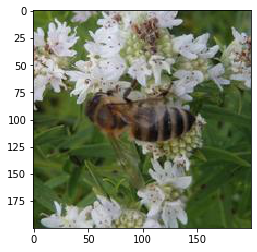

In [19]:
#Honey Bee
bee_example_1 = get_image(labels_df[labels_df.genus==0.0].index[5])
plt.imshow(bee_example_1)

hog_f_1=feature.hog(bee_example_1,pixels_per_cell=(48,48))
y_pred=final_models["svm"].predict([hog_f_1])
print("Predicted label is==>",y_pred)

Predicted correctly

Predicted label is==> [1.]


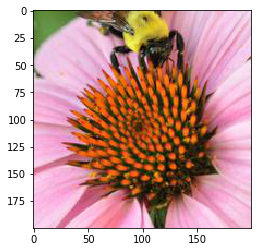

In [20]:
bee_example_2 = get_image(labels_df[labels_df.genus==1.0].index[15])
plt.imshow(bee_example_2)

hog_f_2=feature.hog(bee_example_2,pixels_per_cell=(48,48))
y_pred=final_models["svm"].predict([hog_f_2])
print("Predicted label is==>",y_pred)

Predicted correctly

Predicted label is==> [1.]


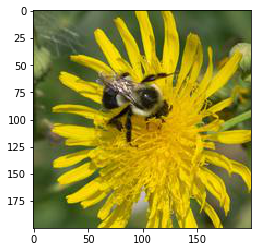

In [21]:
bee_example_3 = get_image(labels_df[labels_df.genus==1.0].index[16])
plt.imshow(bee_example_3)

hog_f_3=feature.hog(bee_example_3,pixels_per_cell=(48,48))
y_pred=final_models["svm"].predict([hog_f_3])
print("Predicted label is==>",y_pred)

Predicted correctly

Predicted label is==> [1.]


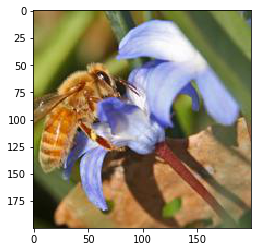

In [22]:
bee_example_4 = get_image(labels_df[labels_df.genus==0.0].index[16])
plt.imshow(bee_example_4)

hog_f_4=feature.hog(bee_example_4,pixels_per_cell=(48,48))
y_pred=final_models["svm"].predict([hog_f_4])
print("Predicted label is==>",y_pred)

Didn't predicted correctly

Predicted label is==> [1.]


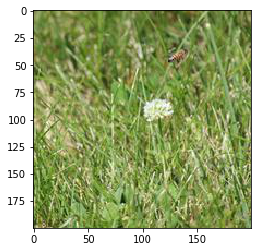

In [24]:
bee_example_5 = get_image(labels_df[labels_df.genus==0.0].index[17])
plt.imshow(bee_example_5)

hog_f_5=feature.hog(bee_example_5,pixels_per_cell=(48,48))
y_pred=final_models["svm"].predict([hog_f_5])
print("Predicted label is==>",y_pred)